##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [65]:
import math
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [66]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [67]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [68]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [69]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [70]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [71]:
##Print a few rows of df:
for i in range(3):
    print(df.iloc[i,:])
    print()

#inputs will be: df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time',]]
#the predicted values: df['VictimCount']

#Scaling has already been done to several of the inputs, with the use of the pd.factorize method. Making them into a integer instead of a string
#As the coordinates fall pretty close to each other, these could be normalized. This is not required it could maybe increase the efficency of the model
#Min/max normalization will therefore be done:
df['X'] = (df['X'] - df['X'].min())/(df['X'].max() - df['X'].min())
df['Y'] = (df['Y'] - df['Y'].min())/(df['Y'].max() - df['Y'].min())

#print a updated row
print(df.iloc[0,:])

X                  -115.087518
Y                    36.216702
Area_Command          0.000000
NIBRSOffenseCode      0.000000
DayOfWeek             0.000000
Time                  0.000000
VictimCount           0.000000
Name: 0, dtype: float64

X                  -115.240172
Y                    36.189693
Area_Command          1.000000
NIBRSOffenseCode      1.000000
DayOfWeek             1.000000
Time                  1.000000
VictimCount           0.000000
Name: 1, dtype: float64

X                  -115.143088
Y                    36.181329
Area_Command          2.000000
NIBRSOffenseCode      1.000000
DayOfWeek             2.000000
Time                  0.000000
VictimCount           1.000000
Name: 2, dtype: float64

X                   0.663899
Y                   0.594478
Area_Command        0.000000
NIBRSOffenseCode    0.000000
DayOfWeek           0.000000
Time                0.000000
VictimCount         0.000000
Name: 0, dtype: float64


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [72]:
## source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = self.dataframe.iloc[idx, :-1] ## everything except last coloumn (VictimCount)
        output = self.dataframe.iloc[idx, -1] 

        ## cast into pytorch tensors, needed for later
        input = torch.tensor(input, dtype=torch.float32) 
        output = torch.tensor(output, dtype=torch.float32)

        return input, output

train, test = train_test_split(df, train_size=0.8)

batch_size = 32
train_dataloader = DataLoader(CustomDataset(train), batch_size=batch_size)
test_dataloader = DataLoader(CustomDataset(train), batch_size=batch_size)

for input_batch, output_batch in train_dataloader:
    print(input_batch.shape)
    print(output_batch.shape)
    break

for input_batch, output_batch in test_dataloader:
    print(input_batch.shape)
    print(output_batch.shape)
    break
    

torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])


C:\Users\ralle\AppData\Local\Temp\ipykernel_23944\3212694298.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input = torch.tensor(input, dtype=torch.float32)


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [73]:
loss_function = torch.nn.MSELoss()
input_size = 6 #The six inputs of the model
output_size = 1 #Since the output is just a real number the output size is just 
layer1_output_size = 12
layer2_output_size = 6
#Since the amount of inputs and outputs are not that big, 3 layers should be enough

regression_model = torch.nn.Sequential(
    torch.nn.Linear(input_size, layer1_output_size), ##input layer
    torch.nn.ReLU(),
    torch.nn.Linear(layer1_output_size, layer2_output_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer2_output_size, output_size)
)

regression_optimizer = torch.optim.Adam(regression_model.parameters(), lr=0.01)


In [74]:
#make training function for next task as well
def train(model, optimizer, loss_function):
    epochs = 25
    
    for epoch in range(epochs):
        model.train()
        cumulated_loss = 0.0
        ##correct_predictions = 0
        
        for inputs_batch, output_batch in train_dataloader:
            optimizer.zero_grad() ##Needed to reset gradients, source: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
            
            predicted_output = model(inputs_batch)
            loss = loss_function(predicted_output, inputs_batch)
            cumulated_loss += loss.data.item()
            
            ##if round(predicted_output.item()) == output_batch:
            ##    correct_predictions += 1
            
            #backwards propagation
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}: Loss= {round(cumulated_loss / len(train_dataloader), 4)}")
        #print(f"Epoch {epoch}: Loss= {cumulated_loss / len(train_dataloader)}, Accuracy: {correct_predictions/len(train_dataloader)}")

    

In [75]:
train(regression_model, regression_optimizer, loss_function)


C:\Users\ralle\AppData\Local\Temp\ipykernel_23944\3212694298.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input = torch.tensor(input, dtype=torch.float32)
C:\Users\ralle\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ralle\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28, 6])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to b

Epoch 1: Loss= 33.067
Epoch 2: Loss= 29.6027
Epoch 3: Loss= 24.4615
Epoch 4: Loss= 23.204
Epoch 5: Loss= 22.9894
Epoch 6: Loss= 22.8198
Epoch 7: Loss= 22.7874
Epoch 8: Loss= 22.7006
Epoch 9: Loss= 22.6967
Epoch 10: Loss= 22.671
Epoch 11: Loss= 22.6575
Epoch 12: Loss= 22.635
Epoch 13: Loss= 22.6248
Epoch 14: Loss= 22.6208
Epoch 15: Loss= 22.6202
Epoch 16: Loss= 22.6189
Epoch 17: Loss= 22.6181
Epoch 18: Loss= 22.6176
Epoch 19: Loss= 22.6171
Epoch 20: Loss= 22.6168
Epoch 21: Loss= 22.6166
Epoch 22: Loss= 22.6164
Epoch 23: Loss= 22.6163
Epoch 24: Loss= 22.6162
Epoch 25: Loss= 22.6162


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [76]:
##since we have already factorized the VictimCount (ouput) coloumn in our dataframe, we can just have the amount of outputs being the amount of different numbers in the coloumn which can be found by taking the max value of the coloumn:
output_size = df['VictimCount'].max()

## else we can use more or less the same architecture, except we need a new loss function:
loss_function = torch.nn.CrossEntropyLoss()

classification_model = torch.nn.Sequential(
    torch.nn.Linear(input_size, layer1_output_size), ##input layer
    torch.nn.ReLU(),
    torch.nn.Linear(layer1_output_size, layer2_output_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer2_output_size, output_size)
)

classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.01)

train(classification_model, classification_optimizer, loss_function)


C:\Users\ralle\AppData\Local\Temp\ipykernel_23944\3212694298.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input = torch.tensor(input, dtype=torch.float32)


Epoch 1: Loss= 31.6379
Epoch 2: Loss= 27.6207
Epoch 3: Loss= 26.3661
Epoch 4: Loss= 25.7886
Epoch 5: Loss= 25.4197
Epoch 6: Loss= 25.1937
Epoch 7: Loss= 25.0738
Epoch 8: Loss= 24.9987
Epoch 9: Loss= 24.94
Epoch 10: Loss= 24.8868
Epoch 11: Loss= 24.8431
Epoch 12: Loss= 24.8044
Epoch 13: Loss= 24.7703
Epoch 14: Loss= 24.7381
Epoch 15: Loss= 24.707
Epoch 16: Loss= 24.678
Epoch 17: Loss= 24.651
Epoch 18: Loss= 24.6245
Epoch 19: Loss= 24.5995
Epoch 20: Loss= 24.5768
Epoch 21: Loss= 24.556
Epoch 22: Loss= 24.537
Epoch 23: Loss= 24.5194
Epoch 24: Loss= 24.5032
Epoch 25: Loss= 24.4881


In [77]:
## calculate accuracy:

classification_model.eval() ##evaluation mode
correct_classifications = 0

for input_batch, output_batch in test_dataloader:
    classifications = classification_model(input_batch)
    _,predicted = torch.max(classifications, 1)
    for i in range(len(test_dataloader)):
        if predicted[i] == output_batch[i]:
            correct_classifications += 1

print(f"Accuracy: {correct_classifications / len(test_dataloader)}")

Accuracy: 0.0


C:\Users\ralle\AppData\Local\Temp\ipykernel_23944\3212694298.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input = torch.tensor(input, dtype=torch.float32)


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

C:\Users\ralle\AppData\Local\Temp\ipykernel_23944\3212694298.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input = torch.tensor(input, dtype=torch.float32)


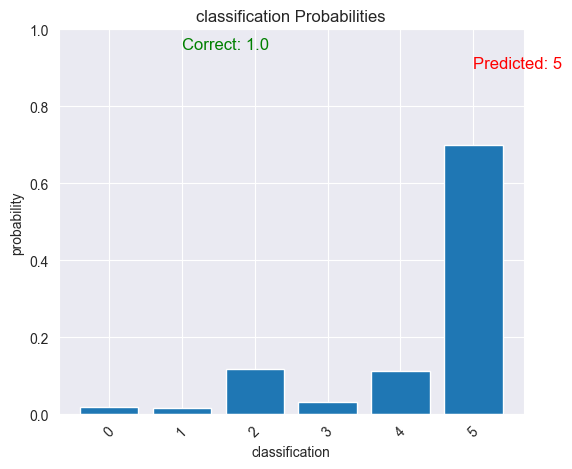

In [78]:
##I'm clearly doing something wrong as the accuracy seems insanely low, even though the amount of instances of some of the victimcounts is low, the accuracy seems too low
##Optimally you would compare results by comparing the accuracy, but when 


with torch.no_grad(): ## errors if i dont do this as i cant get numpy of tensor with a grad
    
    for input_batch, output_batch in test_dataloader:
        classifications = classification_model(input_batch)
    
        classification_probabilities = torch.nn.functional.softmax(classifications, dim=1) ##use softmax to get probabilities
    
        miss_classification_index = 0
        _,predicted = torch.max(classifications, 1)
        for i in range(batch_size):
            if predicted[i] != output_batch[i]:
                miss_classification_index = i
                break
    
        correct_classification = output_batch[miss_classification_index].item()
        miss_classification = predicted[miss_classification_index].item()
    
        plt.figure(figsize=(6, 5))
        plt.bar(range(output_size), classification_probabilities[miss_classification_index].numpy())
        plt.xticks(range(output_size), rotation=45)
        plt.xlabel("classification")
        plt.ylabel("probability")
        plt.title("classification Probabilities")
        plt.ylim([0, 1])
        
        plt.text(correct_classification, 0.95, f'Correct: {correct_classification}', color='green', fontsize=12)
        plt.text(miss_classification, 0.9, f'Predicted: {miss_classification}', color='red', fontsize=12)
        break

            

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


4


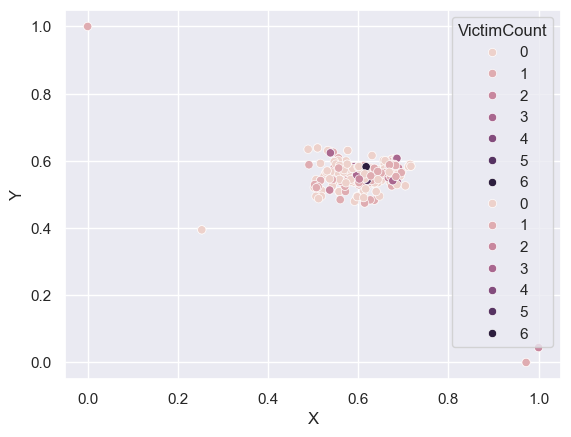

In [89]:
sns.scatterplot(x='X', y='Y', data=df, hue='DayOfWeek') ## No clear pattern

sns.scatterplot(x='X', y='Y', data=df, hue='VictimCount') ## No clear pattern

print(df['DayOfWeek'].value_counts().idxmax()) ## 4, which is friday
# therefore most common day of the crimes reported in the dataset is friday
